Saving monthlysmoothedsunspot.csv to monthlysmoothedsunspot.csv
Saving monthlysunspot.csv to monthlysunspot.csv
0      1749-01-01
1      1749-02-01
2      1749-03-01
3      1749-04-01
4      1749-05-01
          ...    
3293   2023-06-01
3294   2023-07-01
3295   2023-08-01
3296   2023-09-01
3297   2023-10-01
Name: Date, Length: 3298, dtype: datetime64[ns]
      Year  Month  DecimalDate  MonthlyMeanTotalSunspotNumber  \
3119  2008     12     2008.958                            2.2   
3120  2009      1     2009.042                            2.5   
3121  2009      2     2009.123                            2.7   
3122  2009      3     2009.204                            2.9   
3123  2009      4     2009.288                            3.3   
...    ...    ...          ...                            ...   
3247  2019      8     2019.623                            3.4   
3248  2019      9     2019.705                            3.1   
3249  2019     10     2019.790                           

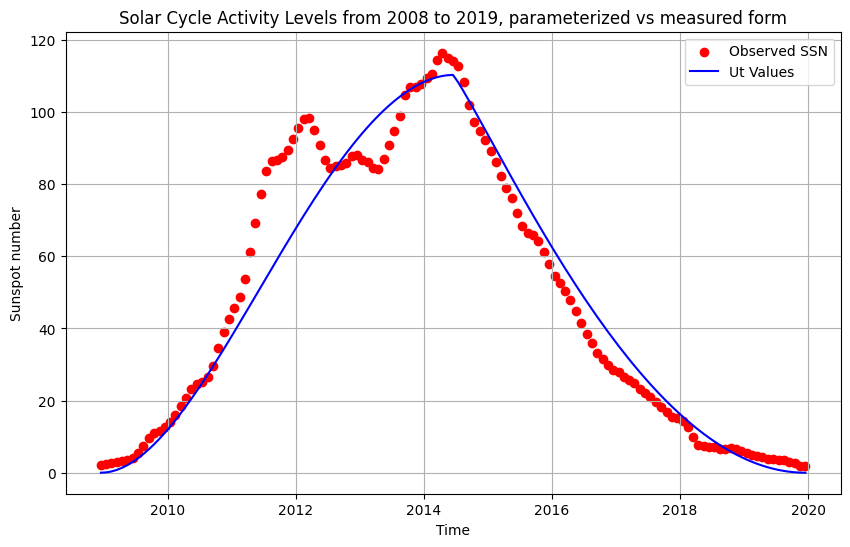

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from google.colab import drive

from google.colab import files
uploaded = files.upload()

# Step 1: Loading and filtering data
monthlysmoothedsunspot_data = pd.read_csv('monthlysmoothedsunspot.csv', sep=';', header=None)
monthlysmoothedsunspot_data.columns = [
    'Year', 'Month', 'DecimalDate', 'MonthlyMeanTotalSunspotNumber',
    'StandardDeviation', 'Observations', 'Definitive/Provisional'
]

monthlysmoothedsunspot_data['Date'] = pd.to_datetime(
    monthlysmoothedsunspot_data['Year'].astype(str) + '-' +
    monthlysmoothedsunspot_data['Month'].astype(str).str.pad(2, fillchar='0'),
    format='%Y-%m'
)
print(monthlysmoothedsunspot_data['Date'])
filtered_data = monthlysmoothedsunspot_data[
    (monthlysmoothedsunspot_data['Date'] >= '2008-12-01') &
    (monthlysmoothedsunspot_data['Date'] <= '2019-12-01')
]
print(filtered_data)

#COPYING ALPHA VALUES FROM PAPER
alpha1 = 1.9
alpha2 = 1.1
c_i = 10.5 # AMPLITUDE VALUE FOR GIVEN CYCLE

# Defining UT functions, square root of sunspot numbers
def Ut_rising(t, c, t_0, t_max, alpha1):
    return c * (1 - ((t_max - t) / (t_max - t_0)) ** alpha1)

def Ut_declining(t, c, t_max, t_1, alpha2):
    return c * (1 - ((t - t_max) / (t_1 - t_max)) ** alpha2)

t_0 = filtered_data['DecimalDate'].min()
t_1 = filtered_data['DecimalDate'].max()
t_max = (t_0 + t_1) / 2  # This is a simplification
ut_values = np.array([
    Ut_rising(t, c_i, t_0, t_max, alpha1) if t < t_max else Ut_declining(t, c_i, t_max, t_1, alpha2)
    for t in filtered_data['DecimalDate']
])
ut_values_squared = np.square(ut_values)
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['DecimalDate'], filtered_data['MonthlyMeanTotalSunspotNumber'], label='Observed SSN', color='red')
plt.plot(filtered_data['DecimalDate'], ut_values_squared, label='Ut Values', color='blue')
plt.xlabel('Time')
plt.ylabel('Sunspot number')
plt.title('Solar Cycle Activity Levels from 2008 to 2019, parameterized vs measured form')
plt.legend()
plt.grid(True)
plt.show()


# New Section

<ipython-input-14-66dfd851b17c>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'Ut_cycle_{index}'] = filtered_data.apply(
<ipython-input-14-66dfd851b17c>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'Ut_cycle_{index}'] = filtered_data.apply(
<ipython-input-14-66dfd851b17c>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

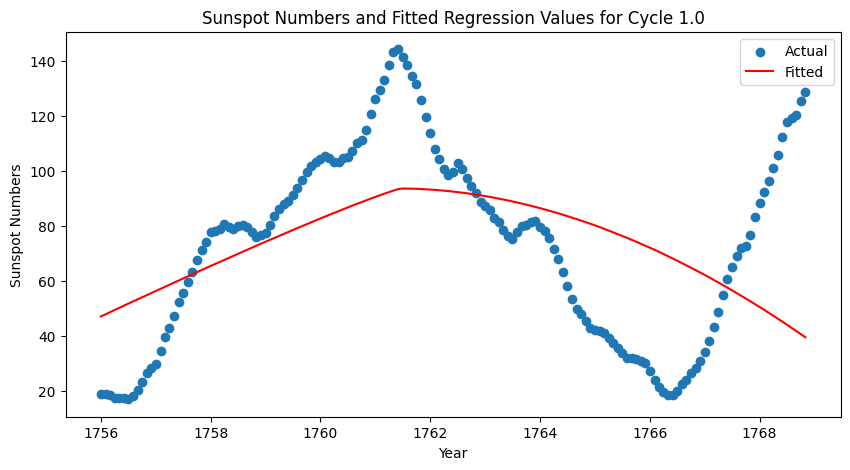

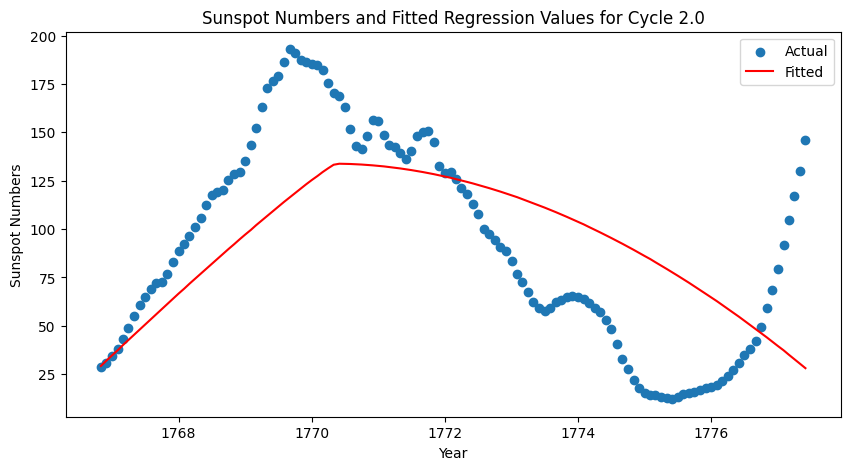

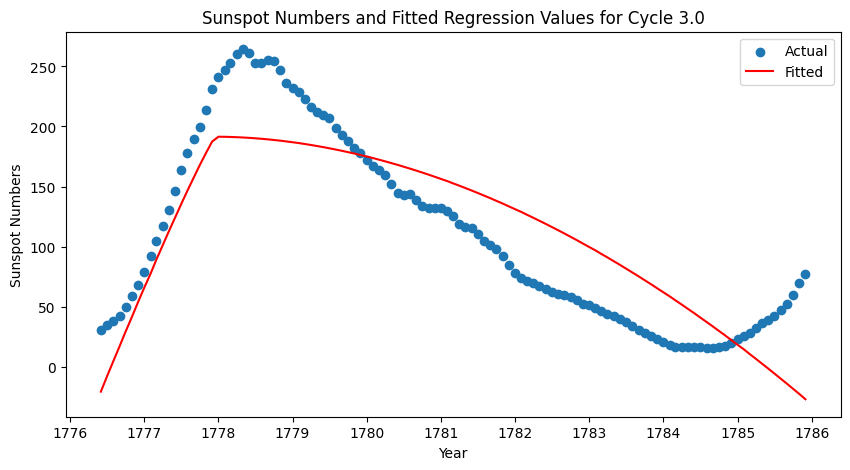

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm  #to fit a basic regression model
import matplotlib.pyplot as plt


monthlysmoothedsunspot_data = pd.read_csv('monthlysmoothedsunspot.csv', sep=';', header=None)
monthlysmoothedsunspot_data.columns = [
    'Year', 'Month', 'DecimalDate', 'MonthlyMeanTotalSunspotNumber',
    'StandardDeviation', 'Observations', 'Definitive/Provisional'
]
monthlysmoothedsunspot_data['Date'] = pd.to_datetime(
    monthlysmoothedsunspot_data['Year'].astype(str) + '-' +
    monthlysmoothedsunspot_data['Month'].astype(str).str.pad(2, fillchar='0'),
    format='%Y-%m'
)

filtered_data = monthlysmoothedsunspot_data[
    (monthlysmoothedsunspot_data['Date'] >= '1756-01-01') &
    (monthlysmoothedsunspot_data['Date'] <= '1786-12-01')
]

# using the values given in Yu et al. for 3 cycles
cycles_parameters = pd.DataFrame({
    'Cycle': [1, 2, 3],
    'C': [8.52, 10.32, 12.25],
    'Alpha1': [1.1, 1.1, 1.1],
    'Alpha2': [1.9, 1.9, 1.9],
    'T0': [1755.2, 1766.8, 1776.4],
    'Tmax': [1761.5, 1770.4, 1778],
    'T1': [1768.9, 1777.5, 1786.0]
})

# Define the Ut functions
def Ut_rising(t, C, T0, Tmax, Alpha1):
    return C * (1 - ((Tmax - t) / (Tmax - T0)) ** Alpha1)

def Ut_declining(t, C, Tmax, T1, Alpha2):
    return C * (1 - ((t - Tmax) / (T1 - Tmax)) ** Alpha2)


for index, cycle_params in cycles_parameters.iterrows():

    filtered_data[f'Ut_cycle_{index}'] = filtered_data.apply(
        lambda row: Ut_rising(row['DecimalDate'], cycle_params['C'], cycle_params['T0'], cycle_params['Tmax'], cycle_params['Alpha1'])
        if row['DecimalDate'] < cycle_params['Tmax']
        else Ut_declining(row['DecimalDate'], cycle_params['C'], cycle_params['Tmax'], cycle_params['T1'], cycle_params['Alpha2']),
        axis=1
    )


    cycle_data = filtered_data[
        (filtered_data['DecimalDate'] >= cycle_params['T0']) &
        (filtered_data['DecimalDate'] <= cycle_params['T1'])
    ]


    X = cycle_data[f'Ut_cycle_{index}']
    y = cycle_data['MonthlyMeanTotalSunspotNumber']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()


    plt.figure(figsize=(10, 5))
    plt.scatter(cycle_data['Date'], y, label='Actual')
    plt.plot(cycle_data['Date'], model.fittedvalues, color='red', label='Fitted')
    plt.xlabel('Year')
    plt.ylabel('Sunspot Numbers')
    plt.title(f'Sunspot Numbers and Fitted Regression Values for Cycle {cycle_params["Cycle"]}')
    plt.legend()